# My LEEDS 2023

Prepares data for the My LEEDS 2023 page 

In [1]:
import os
from events import (
    load_event_data, filter_by_project, prepare, save_files, count_wards
)

Set output directory

In [2]:
OUT_DIR = '../../../../docs/metrics/events/my-leeds-2023/_data/events'

Read in event data and filter by **My LEEDS 2023** project

In [3]:
data = load_event_data().pipe(filter_by_project, '12 - My LEEDS 2023')

Run the processing and save the files

In [4]:
data = data.pipe(prepare).pipe(save_files, OUT_DIR)

In [5]:
SUMMER_OUT_DIR = f'{OUT_DIR}/summer'
os.makedirs(SUMMER_OUT_DIR, exist_ok=True)
data.loc[data.event_name.str.contains('Summer')].pipe(save_files, SUMMER_OUT_DIR)


,actual_audience_size_number_of_participants_in_person,actual_audience_size_number_of_participants_online,airtable_id,end_date,event_name,event_type,event_unique_identifier,number_of_booked_participants,postcode_(from_venue),project_name,project_type,season,start_date,ward_(from_venue),ward_name,ward_code,audience_size
741,600.0,NaN,429,2023-06-11,My LEEDS Summer: Kirkstall,['Public Event - Performance'],12 - My LEEDS 2023: My LEEDS Summer: Kirkstall,NaN,"['LS5 3LX', 'LS4 2DD']",12 - My LEEDS 2023,Produce (Signature),['Season 2 - Playing'],2023-06-11,"['Kirkstall', 'Kirkstall']",Kirkstall,E05011402,600.0
765,500.0,NaN,415,2023-06-17,My LEEDS Summer: Hunslet and Riverside Festiva...,['Public Event - Performance'],12 - My LEEDS 2023: My LEEDS Summer: Hunslet a...,NaN,['LS10 2QT'],12 - My LEEDS 2023,Produce (Signature),['Season 2 - Playing'],2023-06-17,['Hunslet and Riverside'],Hunslet and Riverside,E05011399,500.0
766,2500.0,NaN,396,2023-06-17,My LEEDS Summer: Roundhay World Music and Food...,['Public Event - Performance'],12 - My LEEDS 2023: My LEEDS Summer: Roundhay ...,NaN,"['LS8 1SD', 'LS8 1DF']",12 - My LEEDS 2023,Produce (Signature),['Season 2 - Playing'],2023-06-17,"['Roundhay', 'Roundhay']",Roundhay,E05011411,2500.0
775,3500.0,NaN,419,2023-06-24,My LEEDS Summer: Beeston and Holbeck Part 1/2 ...,['Public Event - Performance'],12 - My LEEDS 2023: My LEEDS Summer: Beeston a...,NaN,['LS11 7BQ'],12 - My LEEDS 2023,Produce (Signature),['Season 2 - Playing'],2023-06-24,['Beeston and Holbeck'],Beeston and Holbeck,E05012647,3500.0
776,400.0,NaN,1769,2023-06-24,My LEEDS Summer: Beeston and Holbeck Part 2/2 ...,['Public Event - Performance'],12 - My LEEDS 2023: My LEEDS Summer: Beeston a...,NaN,['LS11 9NJ'],12 - My LEEDS 2023,Produce (Signature),['Season 2 - Playing'],2023-06-24,['Beeston and Holbeck'],Beeston and Holbeck,E05012647,400.0
777,500.0,NaN,418,2023-06-24,My LEEDS Summer: Crossgates and Whinmoor Celeb...,['Public Event - Performance'],12 - My LEEDS 2023: My LEEDS Summer: Crossgate...,NaN,['LS15 8ET'],12 - My LEEDS 2023,Produce (Signature),['Season 2 - Playing'],2023-06-24,['Cross Gates and Whinmoor'],Cross Gates and Whinmoor,E05011391,500.0
778,NaN,NaN,417,2023-06-24,My LEEDS Summer: Moortown Picnic in the Park,['Public Event - Performance'],12 - My LEEDS 2023: My LEEDS Summer: Moortown ...,NaN,['LS17 6DP'],12 - My LEEDS 2023,Produce (Signature),['Season 2 - Playing'],2023-06-24,['Moortown'],Moortown,E05011405,0.0
804,500.0,NaN,1768,2023-07-01,My LEEDS Summer: Beeston and Holbeck Part 2/2 ...,['Public Event - Performance'],12 - My LEEDS 2023: My LEEDS Summer: Beeston a...,NaN,['LS11 7BQ'],12 - My LEEDS 2023,Produce (Signature),['Season 2 - Playing'],2023-07-01,['Beeston and Holbeck'],Beeston and Holbeck,E05012647,500.0
805,250.0,NaN,423,2023-07-01,My LEEDS Summer: Our Horsforth - Cultural Exch...,['Public Event - Performance'],12 - My LEEDS 2023: My LEEDS Summer: Our Horsf...,NaN,['LS9 0BA'],12 - My LEEDS 2023,Produce (Signature),['Season 2 - Playing'],2023-07-01,['Horsforth'],Horsforth,E05011547,250.0
806,2350.0,NaN,422,2023-07-01,My LEEDS Summer: Wetherby Drovers Day,['Public Event - Performance'],12 - My LEEDS 2023: My LEEDS Summer: Wetherby ...,NaN,['LS22 6NE'],12 - My LEEDS 2023,Produce (Signature),['Season 2 - Playing'],2023-07-01,['Wetherby'],Wetherby,E05011414,2350.0


Print a list of events which have no ward, or more than one

In [6]:
data[data.pipe(count_wards) != 1][[
    'airtable_id',
    'event_name',
    'start_date',
    'ward_(from_venue)',
]]

,airtable_id,event_name,start_date,ward_(from_venue)
768,657,The Gift: Garments,2023-06-17,NaN
770,656,The Gift: digital gift launch,2023-06-19,NaN
828,265,My Leeds Event Day 1 (Live Activation),2023-07-08,NaN
830,430,My LEEDS Summer: Alwoodley Festival of Sport a...,2023-07-09,"['Alwoodley', 'Alwoodley', 'Alwoodley', 'Alwoo..."
889,266,My Leeds Event Day 2 (Live Activation),2023-08-05,NaN


Print a list of events with no audience recorded

In [7]:
data[data.audience_size == 0][[
    'airtable_id', 'event_name', 'start_date', 'audience_size'
]]

,airtable_id,event_name,start_date,audience_size
265,560,Pudsey Grant Info Session,2023-02-13,0.0
266,561,Rothwell Grant Info Session,2023-02-13,0.0
268,562,Roundhay Grant Info Session 1,2023-02-13,0.0
280,567,Wetherby Grant Info Session 1,2023-02-14,0.0
289,565,Weetwood Grant Info Session 1,2023-02-15,0.0
300,563,Roundhay Grant Info Session 2,2023-02-16,0.0
303,564,Temple Newsam Grant Info Session,2023-02-16,0.0
315,566,Weetwood Grant Info Session 2,2023-02-19,0.0
323,558,Otley and Yeadon Grant Info Session 1,2023-02-20,0.0
334,559,Otley and Yeadon Grant Info Session 2,2023-02-21,0.0


event_type
['Public Event - Digital Experience']     1
['Public Event - Installation']           1
['Public Event - Performance']           29
['Public Event - Talk / Tour']           11
Name: event_name, dtype: int64

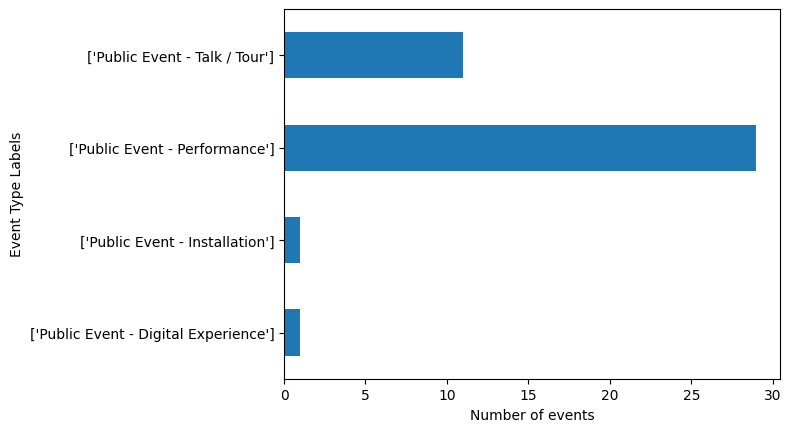

In [8]:
plot = data.groupby('event_type').event_name.count().plot.barh()
plot.xaxis.label.set_text('Number of events')
plot.yaxis.label.set_text('Event Type Labels')
data.groupby('event_type').event_name.count()